In [1]:
# Load modules
using Plots
using NCDatasets
using Statistics: mean
using DelimitedFiles
using PrettyTables
using PaddedViews
using Dates
using Printf 


In [17]:

# Useful functions
function get_var(file_name, var_name, t_spinup, nan_fill_value);
    ds = NCDataset(file_name, "r");
    var = ds[var_name][:];
    data=var[:, :, :, t_spinup:end]; # cut out the spinup;
    replace!(data, NaN=>nan_fill_value)
    return data
    none
end

function get_zonal_mean(file_name, var_name, nan_fill_value);
    ds = NCDataset(file_name, "r");
    var = ds[var_name][:];
    data_mean = mean( var[:,:,:,:], dims=1); # lon, lat,lev, time
    replace!(data_mean, NaN=>nan_fill_value)
    return data_mean[1,:,:,:]
    none
end

function get_zonal_mean_time_mean(file_name, var_name, nan_fill_value,t_spinup);
    ds = NCDataset(file_name, "r");
    var = ds[var_name][:];
    data_mean = mean(mean( var[:,:,:,t_spinup:end], dims=4),dims=1); # lon, lat,lev, time
    replace!(data_mean, NaN=>nan_fill_value)
    return data_mean[1,:,:,1]
    none
end

function get_slice(
                   file_name, var_name, nan_fill_value,
                   lon_i1, lon_12, lat_i1, lat_i2, lev_i1, lev_i2, t_i1, t_i2);
    
    ds = NCDataset(file_name, "r");
    var = ds[var_name][:];
    data = (var[lon_i1:lon_12, lat_i1:lat_i2, lev_i1:lev_i2, t_i1:t_i2]); # create statistics
    replace!(data, NaN=>nan_fill_value)
    return data
    none
end

function get_coords(file_name)
    ds = NCDataset(file_name, "r");
    lon = ds["long"][:];
    lat = ds["lat"][:];
    lev = ds["level"][:] / 1e3; # height in kilometers
    time = ds["time"][:];  # time
    close(ds)
    return lon, lat, lev, time
    none
end

function get_min_max(var);
    vmax = maximum(filter(!isnan,var))
    vmin = minimum(filter(!isnan,var))
    return vmin,vmax
    none
end

function get_short_expname(fname, var_code_1)
    "gets substring between var_code_1 and the following '_' "
    driver = fname
    exp_name =  split(split(driver,var_code_1)[2],"_")[1] 
    return exp_name
end

get_short_expname (generic function with 1 method)

In [3]:
# Specify needed directories and filenames: these will be replaced automatically by the bash run script or can be modified manually
CLIMA_ANALYSIS = "/central/scratch/elencz/output/hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280/analysis"
CLIMA_NETCDF = "/central/scratch/elencz/output/hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280/netcdf"
CLIMA_LOGFILE = "/central/scratch/elencz/output/hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280/log/experiments_performance_log"
RUNNAME = "hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280"


"hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280"

In [4]:
# Get the current and previous  GCM netcdf file names in the CLIMA_NETCDF directory
fnames = filter(x -> occursin(".nc", x), readdir( CLIMA_NETCDF ) );


# set file name 
filename = "$CLIMA_NETCDF/"fnames[3]

# print data info:
ds = NCDataset(filename, "r") 

NCDataset: /central/scratch/elencz/output/hier_gcmdriver_master_micro0-200qct+upperdamp_bulkflux_hsua_diff10_poly3_spongeUandETandRHOthinner22km_refstateT280/netcdf/HeldSuarez_AtmosGCMDefault_2020-09-05T23.05.31.225.nc
Group: /

Dimensions
   long = 361
   lat = 181
   level = 31
   time = 401

Variables
  long   (361)
    Datatype:    Float64
    Dimensions:  long
    Attributes:
     units                = degrees_east
     long_name            = longitude

  lat   (181)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     units                = degrees_north
     long_name            = latitude

  level   (31)
    Datatype:    Float64
    Dimensions:  level
    Attributes:
     units                = m
     long_name            = level

  time   (401)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     units                = seconds since 1900-01-01 00:00:00
     long_name            = time

  u   (361 × 181 × 31 × 401)
    Datatype:    Float64
    Dime

In [5]:
# get coordinates
lon, lat, lev, time = get_coords(filename);

nan_fill_value = -9999
nexp = size(fnames);
print(fnames)

["1HeldSuarez_AtmosGCMDefault_2020-09-05T14.52.45.302_22kmsponge_refstateT290.nc", "HeldSuarez_AtmosGCMDefault_2020-09-05T14.52.45.302_12kmsponge_refstateT290.nc", "HeldSuarez_AtmosGCMDefault_2020-09-05T23.05.31.225.nc"]

In [32]:
#Slices
t_slice = 90*4

z_slice = 8

# vertical 
lon_i1, lon_12, lat_i1, lat_i2, lev_i1, lev_i2, t_i1, t_i2 = [1, length(lon), 1 , length(lat), z_slice, z_slice, t_slice , t_slice ]

plot_array = Any[]

"""
hs_c = get_slice( filename, "u", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 8, 8, t_i1, t_i2);
title = "u"*"_7km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title=title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);

hs_c = get_slice( filename, "v", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 6, 6, t_i1, t_i2);
title = "v"*"_5km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title= title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);


hs_c = get_slice( filename, "temp", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 1, 1, t_i1, t_i2);
title = "temp"*"_0km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title=title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);



hs_c = get_slice( filename, "vort", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 6, 6, t_i1, t_i2);
title = "vort"*"_5km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title=title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);


hs_c = get_slice( filename, "qt", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 8, 8, t_i1, t_i2);
title = "qt"*"_7km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title=title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);
"""
hs_c = get_slice( filename, "qi", nan_fill_value, lon_i1, lon_12, lat_i1, lat_i2, 8, 8, t_i1, t_i2);
title = "qi"*"_7km_day"*string(t_slice)
one_plot = contourf( lon, lat, (hs_c[:,:,1,1])', title=title, xlabel="lon (deg)", ylabel="lat (deg N)");
push!(plot_array,one_plot);


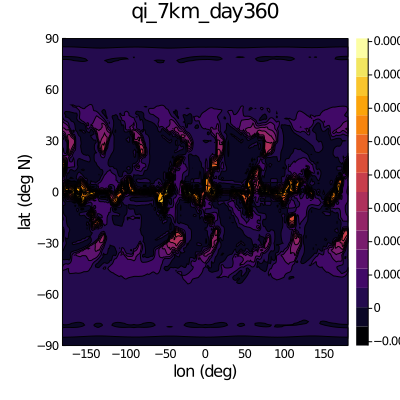

In [33]:


fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_vertslice_indivDEL_$title",".pdf"));

# Zonal and time means

In [30]:
# get_zonal_means
t_spinup = 50*4

plot_array = Any[]; # can type this more strictly

zm_c = get_zonal_mean_time_mean(filename, "u", nan_fill_value,t_spinup)



181×31 Array{Float64,2}:
  0.000319576   0.000184919   6.85133e-5  …   2.65008e-5   3.02484e-5
  0.599441      0.273754     -0.0685029      -0.00076845   0.00513417
  0.956567      0.382079     -0.222066       -0.00218686   0.00961498
  1.15377       0.382752     -0.428843       -0.00384065   0.0139049
  1.20247       0.284521     -0.682927       -0.00568954   0.018033
  1.11406       0.0960321    -0.978563    …  -0.00767769   0.0220429
  0.899941     -0.174137     -1.31012        -0.0097334    0.0259934
  0.571553     -0.517446     -1.67208        -0.0117686    0.0299583
  0.225304     -0.850532     -1.99403        -0.0133242    0.0336182
  0.0442121    -1.02442      -2.16074        -0.0136229    0.0361474
 -0.116073     -1.16786      -2.28606     …  -0.0135704    0.0380096
 -0.29316      -1.31592      -2.40251        -0.0135448    0.039205
 -0.501492     -1.48293      -2.52433        -0.0135773    0.0398735
  ⋮                                       ⋱                ⋮
 -0.319366     -

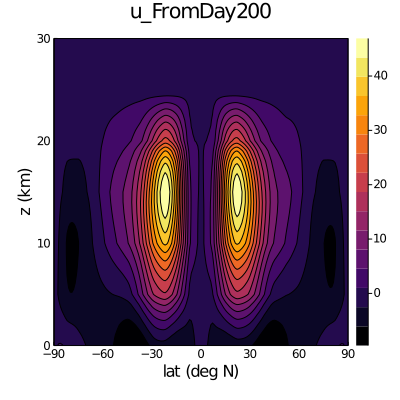

In [31]:

title = "u_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_c[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [34]:
# get_zonal_means
plot_array = Any[]; # can type this more strictly
zm_temp = get_zonal_mean_time_mean(filename, "temp", nan_fill_value,t_spinup)


181×31 Array{Float64,2}:
 298.486  289.561  280.646  271.69   …  219.791  220.183  219.882  217.989
 297.708  288.847  280.025  271.201     219.79   220.185  219.886  217.99
 296.929  288.136  279.409  270.712     219.788  220.188  219.889  217.989
 296.151  287.431  278.798  270.223     219.787  220.19   219.892  217.987
 295.376  286.73   278.191  269.734     219.786  220.193  219.894  217.984
 294.606  286.036  277.589  269.245  …  219.785  220.195  219.896  217.979
 293.843  285.348  276.99   268.755     219.784  220.196  219.896  217.973
 293.091  284.667  276.397  268.264     219.783  220.198  219.896  217.966
 292.333  283.98   275.792  267.756     219.783  220.2    219.897  217.958
 291.574  283.278  275.163  267.221     219.781  220.203  219.898  217.95
 290.829  282.586  274.539  266.686  …  219.78   220.206  219.9    217.942
 290.103  281.909  273.928  266.161     219.778  220.21   219.902  217.933
 289.396  281.252  273.335  265.653     219.776  220.213  219.904  217.924
  

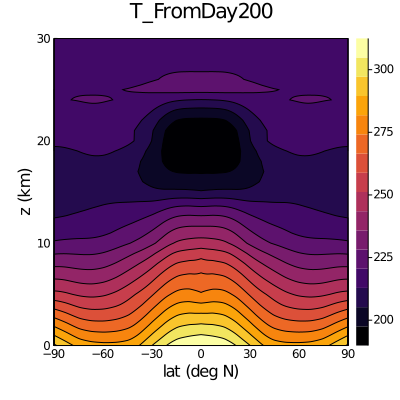

In [35]:

title = "T_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_temp[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [36]:
# get_zonal_means
plot_array = Any[]; # can type this more strictly
zm_v = get_zonal_mean_time_mean(filename, "v", nan_fill_value,t_spinup)

181×31 Array{Float64,2}:
  0.000691687   0.000446376   0.00021257   …   2.86966e-5   3.18352e-5
 -0.51898      -0.279274     -0.0744379       -0.00894413  -0.0136727
 -0.716574     -0.364885     -0.0723008       -0.00505254  -0.0127842
 -0.813196     -0.390982     -0.0477183       -0.00104366  -0.0115258
 -0.816308     -0.362444     -0.00310061       0.0030148   -0.00996172
 -0.733268     -0.284016      0.0592673    …   0.00705542  -0.00815749
 -0.571332     -0.160321      0.137221         0.0110108   -0.00617964
 -0.337665      0.00413922    0.228714         0.0148132   -0.00409617
 -0.168827      0.117795      0.287319         0.0121815   -0.00888661
 -0.21721       0.0790595     0.261407         0.0107599   -0.0119307
 -0.296785      0.0170115     0.221506     …   0.0103507   -0.0133205
 -0.359733     -0.0347907     0.186336         0.0102707   -0.0137929
 -0.383845     -0.0609436     0.164266         0.0103388   -0.0135542
  ⋮                                        ⋱               

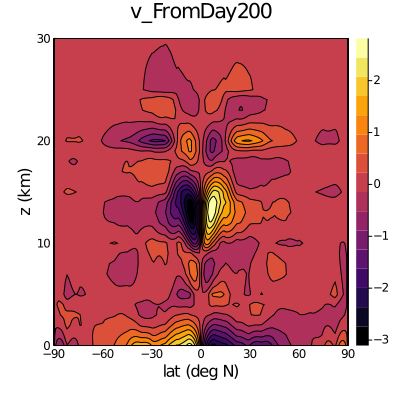

In [37]:

title = "v_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_v[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [38]:
# get_zonal_means

plot_array = Any[]; # can type this more strictly

zm_w = get_zonal_mean_time_mean(filename, "w", nan_fill_value,t_spinup)

181×31 Array{Float64,2}:
 -0.034821     -0.0141089     0.00360423   …  -0.00342054  0.000797113
 -0.00548939    0.0013932     0.00687278      -0.00330766  0.000802134
  0.00693925    0.00701588    0.0065964       -0.00322476  0.000774855
  0.00824904    0.00627639    0.00422165      -0.00317157  0.000728841
  0.00364534    0.0022995     0.000984268     -0.00314717  0.000678775
 -0.00213061   -0.00208817   -0.00202137   …  -0.00315176  0.000637487
 -0.00478339   -0.00434087   -0.0038287       -0.00318667  0.000615908
 -0.000446519  -0.00217761   -0.00358601      -0.00325424  0.000623019
 -0.00247904   -0.0019385    -0.00136983      -0.00328887  0.000574281
  0.00131594    0.0013        0.00120787      -0.00331202  0.000545191
  0.00368777    0.00302592    0.00227796   …  -0.00333628  0.000505824
  0.00285567    0.00238434    0.00182599      -0.00335532  0.000453432
  0.000379756   0.000425985   0.000413736     -0.00337508  0.000397745
  ⋮                                        ⋱        

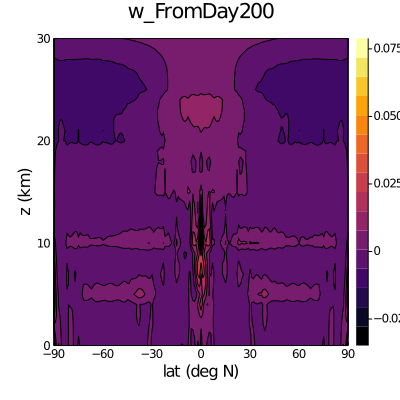

In [39]:
title = "w_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_w[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [40]:
# get_zonal_means
plot_array = Any[]; # can type this more strictly
zm_qt = get_zonal_mean_time_mean(filename, "qt", nan_fill_value,t_spinup)

181×31 Array{Float64,2}:
 0.000143877  0.0001369    0.000130398  …  2.36496e-9   9.06422e-9
 0.000267719  0.000253788  0.000237789     2.7475e-9    6.20954e-9
 0.000387319  0.000366055  0.000340443     2.91311e-9   4.25399e-9
 0.000502603  0.000473719  0.000438443     2.90628e-9   2.77587e-9
 0.000613545  0.000576819  0.000531867     2.73717e-9   1.7945e-9
 0.000720099  0.000675379  0.000620784  …  2.42068e-9   1.30876e-9
 0.000822198  0.000769404  0.000705249     1.97659e-9   1.29682e-9
 0.000919755  0.000858881  0.000785303     1.42968e-9   1.71583e-9
 0.00100959   0.000940882  0.000858083     9.50943e-10  1.91446e-9
 0.00108779   0.00101146   0.000919432     8.2091e-10   1.41789e-9
 0.00116115   0.00107742   0.000976338  …  7.77463e-10  8.43558e-10
 0.0012317    0.00114068   0.00103073      7.16253e-10  4.44534e-10
 0.00130011   0.00120184   0.00108312      6.10725e-10  3.18636e-10
 ⋮                                      ⋱               ⋮
 0.00123305   0.00114177   0.00103148      6

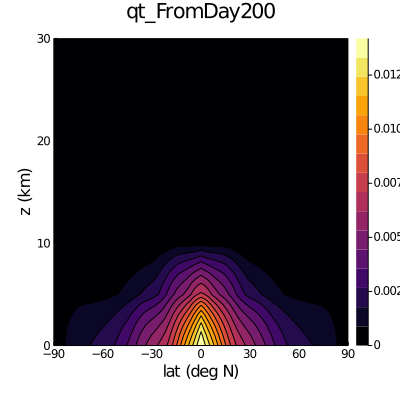

In [41]:
title = "qt_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_qt[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(400, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [42]:
# get_zonal_means
zm_ql = get_zonal_mean_time_mean(filename, "ql", nan_fill_value,t_spinup)

181×31 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

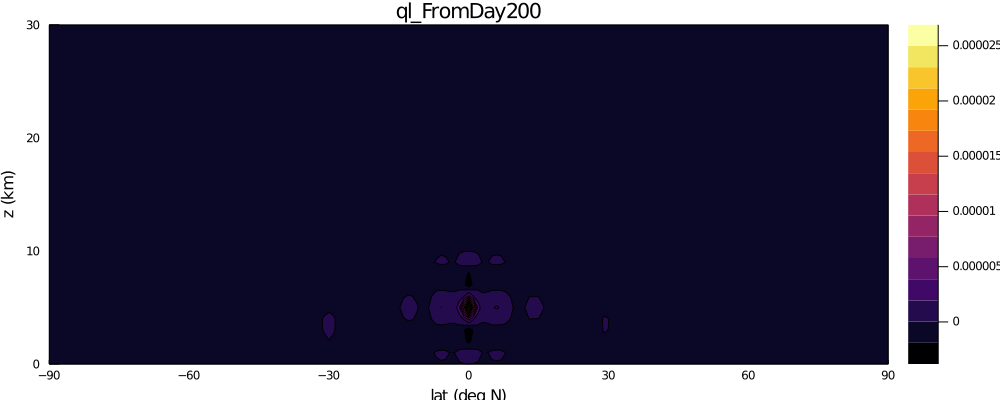

In [55]:
plot_array = Any[]; # can type this more strictly
title = "ql_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_ql[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1), size=(1000, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [44]:
# get_zonal_means

plot_array = Any[]; # can type this more strictly
zm_qi = get_zonal_mean_time_mean(filename, "qi", nan_fill_value,t_spinup)

181×31 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   3.80788e-20     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   8.57783e-20     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -1.90732e-21     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -1.80717e-20     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -3.38234e-19     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -1.88273e-18     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -1.79956e-18     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -2.89424e-20  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -3.00103e-19     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -2.97705e-20     0.0  0.0

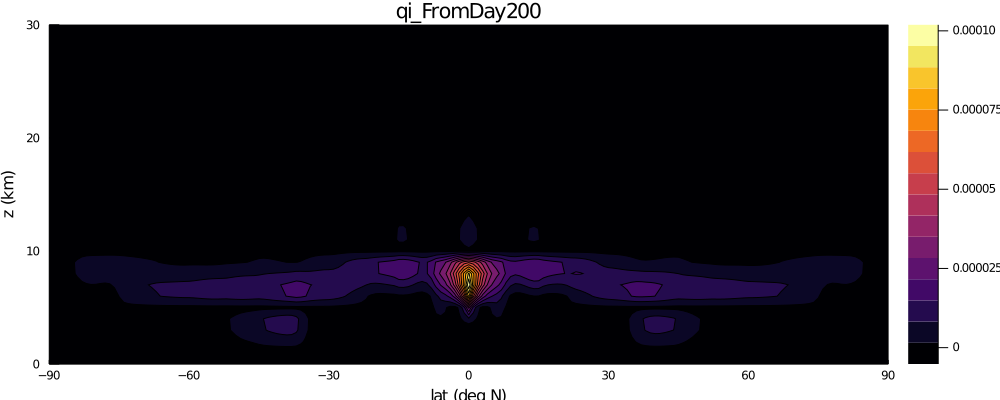

In [56]:
plot_array = Any[]; # can type this more strictly
title = "qi_FromDay"*string(t_spinup)
one_plot = contourf( lat, lev, (zm_qi[:,:])' , title=title, xlabel="lat (deg N)", ylabel="z (km)");
push!(plot_array,one_plot); # make a plot and add it to the plot_array
fig=plot(plot_array... , layout=(1, 1), size=(1000, 400) )
display(fig)
savefig(fig, string("$CLIMA_ANALYSIS/plot_zonaltimemean_indivDEL_$title",".pdf"));

In [50]:
t_spinup

200